# Variational Autoencoder



## 실습 목표
-----
- VAE를 설계하고 학습시켜 이미지를 생성하는 모델을 만듭니다. (데이터셋: MNIST)


## 문제 정의

- VAE

![image](https://upload.wikimedia.org/wikipedia/commons/1/11/Reparameterized_Variational_Autoencoder.png)

## VAE

### [Step1] Load libraries & Datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch.nn as nn
import torch.nn.functional as F
import torch

In [3]:
train_images = datasets.MNIST(
    root= 'data',
    train= True,
    download= True,
    transform= ToTensor() 
)

test_images = datasets.MNIST(
    root= 'data',
    train= True,
    download= True,
    transform= ToTensor() 
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### [Step2] Set hyperparameters

In [4]:
# 하이퍼파라미터 준비
EPOCH = 10
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


### [Step3] Create DataLoader

In [5]:
train_loader = DataLoader(train_images, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_images, batch_size = BATCH_SIZE, shuffle = True)

### [Step4] Set Network Structure ([구조](https://upload.wikimedia.org/wikipedia/commons/1/11/Reparameterized_Variational_Autoencoder.png))

In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dim): # latent_dim 잠재벡터 z의 차원을 의미함
        super(VAE, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_var = nn.Linear(256, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
        )

    def encode(self, x):            
        result = self.encoder(x)
        mu = self.fc_mu(result)  # encoder로 부터 나온 값인 result가 mu와 var에 각각 들어간다
        var = self.fc_var(result)
        return mu, var

    def decode(self, z):
        result = self.decoder(z)
        return result   

    def reparameterize(self, mu, var):
        std = torch.exp(var / 2)
        eps = torch.randn_like(std)
        return mu + (eps * std) 

    def forward(self, x):
        x = self.flatten(x)
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        out = self.decode(z)
        return  out, mu, var

### [Step5] Create Model instance

In [7]:
model = VAE(10).to(DEVICE)
print(model)

VAE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=10, bias=True)
  (fc_var): Linear(in_features=256, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


### [Step6] Model compile

In [8]:
def loss_function(recon_x, x, mu, var):
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + var - mu.pow(2) - var.exp())
    return recon_loss + kl_loss
    # recon_loss는 x가 x'와 얼마나 유사한지 나타내는 것이며 베르누이 분포를 따른다고 가정하여서 binary cross entropy
    # kl_loss 는 x가 정규분포를 가진다고 가정하였을때 근사한 정규분포를 만들어 얼마나 유사한지를 비교하는 함수
optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)

### [Step7] Set train loop

In [9]:
def train(train_loader, model, loss_fn, optimizer):
    model.train()

    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(DEVICE), y.to(DEVICE)
        decoded, mu, var= model(X)

        # 손실계산
        loss = loss_fn(decoded, X, mu, var)

        # 역전파
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

    # 결과 시각화
    origin_data = X[:5].view(-1, 28*28).type(torch.FloatTensor)/255.
    decoded_data = decoded[:5].view(-1, 28*28).type(torch.FloatTensor)/255.
 
    f, axs = plt.subplots(2, 5, figsize=(5, 2))    
    for i in range(5):
        img = np.reshape(origin_data.data.numpy()[i],(28, 28))
        axs[0][i].imshow(img, cmap='gray')
        axs[0][i].set_xticks(())
        axs[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28)) 
        axs[1][i].imshow(img, cmap='gray')
        axs[1][i].set_xticks(()) 
        axs[1][i].set_yticks(())
    plt.show()

### [Step8] Run Model

Epoch 1 
------------------------


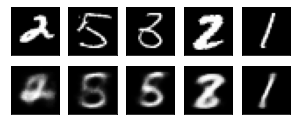

Epoch 2 
------------------------


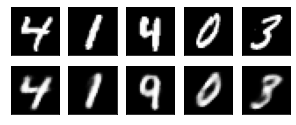

Epoch 3 
------------------------


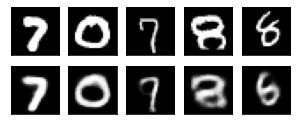

Epoch 4 
------------------------


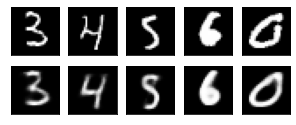

Epoch 5 
------------------------


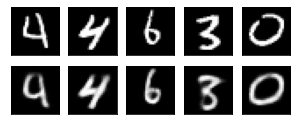

Epoch 6 
------------------------


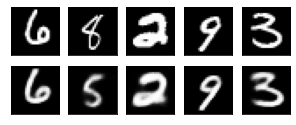

Epoch 7 
------------------------


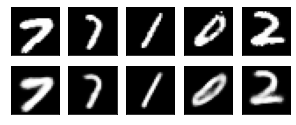

Epoch 8 
------------------------


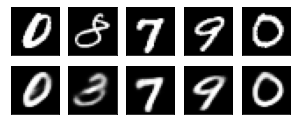

Epoch 9 
------------------------


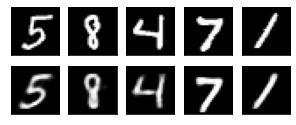

Epoch 10 
------------------------


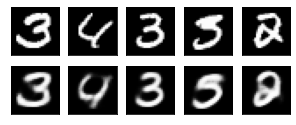

In [10]:
for i in range(EPOCH):
    print(f"Epoch {i+1} \n------------------------")
    train(train_loader, model, loss_function, optimizer)

- reference
    - https://github.com/lyeoni/pytorch-mnist-VAE/blob/master/pytorch-mnist-VAE.ipynb
    - https://subinium.github.io/VAE-AE/
    - https://github.com/AntixK/PyTorch-VAE/blob/a6896b944c918dd7030e7d795a8c13e5c6345ec7/models/vanilla_vae.py#L2
    - https://www.slideshare.net/NaverEngineering/ss-96581209
    - https://github.com/pytorch/examples/blob/main/vae/main.py
